df shape: (128, 15)
df first row:          0         1         2         3         4         5         6   \
0 -0.193574  0.113979 -0.005927  0.300957 -0.358603 -0.087866 -0.156226   

         7         8         9         10        11        12        13   14  
0  0.342442 -0.016003  0.143113  0.256422 -0.164125 -0.136743  0.014674  1.0  
df cols: Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64')

X_train type: <class 'numpy.ndarray'> (20, 14)
X_train first row: [-0.10000625  0.00243083  0.24421757  0.12686991 -0.06389124 -0.085588
  0.07249021  0.04298629 -0.0527142   0.01975425 -0.15931417 -0.40999085
 -0.19961527  0.05384521]


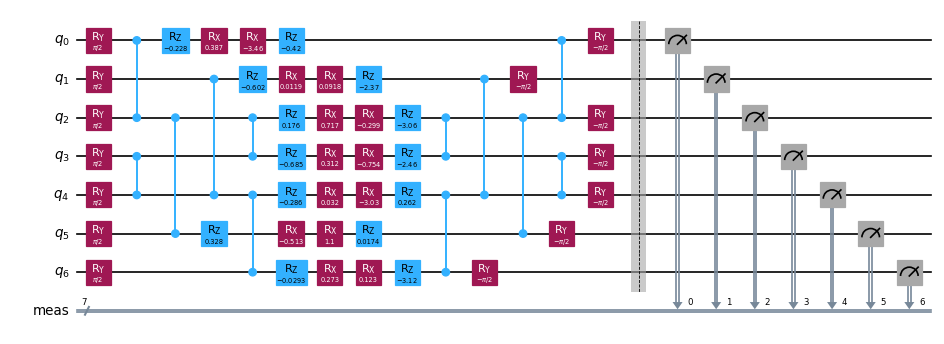

In [12]:
# Import some qiskit packages required for setting up our quantum circuits.
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qiskit.circuit.library import unitary_overlap
 
# Import StatevectorSampler as our sampler.
from qiskit.primitives import StatevectorSampler
 
# Step 1: Map classical inputs to a quantum problem:
 
# Start by getting some appropriate data. The data imported below consist of 128 rows or data points.
# Each row has 14 columns that correspond to data features, and a 15th column with a label (+/-1).
#!wget https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv
 
# Import some required packages, and write a function to pull some training data out of the csv file you got above.
import pandas as pd
import numpy as np
 
 
def get_training_data():
    """Read the training data."""
    df = pd.read_csv("dataset_graph7.csv", sep=",", header=None)
    training_data = df.values[:20, :]
    ind = np.argsort(training_data[:, -1])
    X_train = training_data[ind][:, :-1]

    print("df shape:", df.shape)
    print("df first row:", df.head(1))
    print("df cols:", df.columns)
    
    return X_train
 
 
# Prepare training data
X_train = get_training_data()

print()
print("X_train type:", type(X_train), X_train.shape)
print("X_train first row:", X_train[0])

# Empty kernel matrix
num_samples = np.shape(X_train)[0]
 
# Prepare feature map for computing overlap between two data points.
# This could be pre-built feature maps like ZZFeatureMap, or a custom quantum circuit, as shown here.
num_features = np.shape(X_train)[1]
num_qubits = int(num_features / 2)
entangler_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]
fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)
 
# Pick two data points, here 14 and 19, and assign the features to the circuits as parameters.
x1 = 14
x2 = 19
unitary1 = fm.assign_parameters(list(X_train[x1]) + [np.pi / 2])
unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])
 
# Create the overlap circuit
overlap_circ = unitary_overlap(unitary1, unitary2)
overlap_circ.measure_all()
overlap_circ.draw("mpl", scale=0.6, style="iqp")

In [20]:
# Step 2: Optimize problem for quantum execution
 
# Use Qiskit Runtime service to get the least busy backend for running on real quantum computers.
# from qiskit_ibm_runtime import QiskitRuntimeService
 
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(
#    operational=True, simulator=False, min_num_qubits=overlap_circ.num_qubits
# )
 
# Transpile the circuits optimally for the chosen backend using a pass manager.
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
# overlap_ibm = pm.run(overlap_circ)
 
# Step 3: Execute using Qiskit Runtime Primitives
 
# Specify the number of shots to use.
num_shots = 10_000
 
## Evaluate the problem using statevector-based primitives from Qiskit
sampler = StatevectorSampler()
counts = (
    sampler.run([overlap_circ], shots=num_shots).result()[0].data.meas.get_int_counts()
    #sampler.run([overlap_circ], shots=num_shots).result()[0].data.meas.get_counts()
)
 
# Step 4: Analyze and post-processing

print("counts type:", type(counts), len(counts))
#print("counts keys:", counts.keys())

# Find the probability of 0.
counts.get(0, 0.0) / num_shots

counts type: <class 'dict'> 42


0.0